# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Critical methodological note: dataset selection by model type

**This notebook uses TWO different preprocessed datasets from Task 1**, depending on algorithmic requirements:

---

#### Dataset 1: ordinal encoder 
**Features:** 19 columns (categorical → ordinal integers: race=0,1,2,...)

**Valid for: Tree-based models**
- Random Forest, Decision Trees, Gradient Boosting, XGBoost
- **Why?** Tree splits are **order-invariant**: `race < 1.5` vs `race >= 1.5` doesn't care if White=0 or White=5
- **Advantage:** Compact (19 features), fast training

**Invalid for: Linear models**
- **Problem:** Linear regression equation
- If `Occupation=1` (Teacher) and `Occupation=9` (Engineer), model calculates `9 × w_occupation` vs `1 × w_occupation`
- **Implies engineers have 9× the coefficient impact of teachers** - semantically absurd for nominal variables
- **Result:** Ridge, Lasso, SGDRegressor perform poorly (R² ~0.13) due to false linear relationships from arbitrary ordinal encoding

---

#### Dataset 2: mixed encoding 
**Features:** ~26 columns (One-Hot for sex/race/relationship, Target for occupation/country, Ordinal for income/education)

**Valid for: Linear models**
- Ridge, Lasso, SGDRegressor, Linear Regression
- **Why?** Each nominal category gets either:
  - **Independent coefficient** (One-Hot): `sex_Male=1` → separate weight, not multiplied by arbitrary integers
  - **Semantically scaled value** (Target): `occupation_encoded=42.5` → mean hours for that occupation, not arbitrary order




---

#### Implementation strategy
1. **Linear models section**: Load `census_data_preprocessed_mixed.csv` (!!!train/test split NOT pre-made, split here!!!)
2. **Tree-based models section**: Load `census_data_train.csv` + `census_data_test.csv` (OrdinalEncoder, pre-split)
3. **Comparison section**: Demonstrate performance difference with proper encoding

**Rationale:** Maximize both methodological correctness (proper encoding for each algorithm) and computational efficiency (compact encoding where valid).

In [2]:
print("Loading datasets: Different encodings for different model types")
print("-" * 80)

# Dataset 1: OrdinalEncoder (for TREE-BASED models)
print("\nDataset 1: OrdinalEncoder (census_data_train.csv, census_data_test.csv)")
train_data_ordinal = pd.read_csv('preprocessed_data/census_data_train.csv')
test_data_ordinal = pd.read_csv('preprocessed_data/census_data_test.csv')

print(f"   Train shape: {train_data_ordinal.shape}")
print(f"   Test shape: {test_data_ordinal.shape}")
print(f"   Features: {train_data_ordinal.shape[1]}")
print(f"   Valid for: Random Forest, Decision Trees, Gradient Boosting")
print(f"   Reason: Order-invariant splits (race < 1.5)")

# Dataset 2: Mixed Encoding (for LINEAR models)
print("\nDataset 2: Mixed encoding (census_data_preprocessed_mixed.csv)")
data_mixed = pd.read_csv('preprocessed_data/census_data_preprocessed_mixed.csv')

print(f"   Shape: {data_mixed.shape}")
print(f"   Features: {data_mixed.shape[1]}")
print(f"   Encoding: One-Hot (sex, race, relationship) + Target (occupation, country) + Ordinal (income, education)")
print(f"   Valid for: Ridge, Lasso, SGDRegressor")
print(f"   Reason: Independent/scaled coefficients, no false linear relationships")

# Create train/test split for mixed encoding dataset (80-20)
from sklearn.model_selection import train_test_split
X_mixed = data_mixed.drop('hours-per-week', axis=1)
y_mixed = data_mixed['hours-per-week']

X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(
    X_mixed, y_mixed, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n   Mixed encoding split:")
print(f"   Train: {X_train_mixed.shape}, Test: {X_test_mixed.shape}")

print("\nDataset loading complete")
print("-" * 80)

# Display sample from ordinal dataset
print("\nSample from OrdinalEncoder dataset (tree-based models):")
train_data_ordinal.head()

Loading datasets: Different encodings for different model types
--------------------------------------------------------------------------------

Dataset 1: OrdinalEncoder (census_data_train.csv, census_data_test.csv)
   Train shape: (26029, 19)
   Test shape: (6508, 19)
   Features: 19
   Valid for: Random Forest, Decision Trees, Gradient Boosting
   Reason: Order-invariant splits (race < 1.5)

Dataset 2: Mixed encoding (census_data_preprocessed_mixed.csv)
   Shape: (32537, 26)
   Features: 26
   Encoding: One-Hot (sex, race, relationship) + Target (occupation, country) + Ordinal (income, education)
   Valid for: Ridge, Lasso, SGDRegressor
   Reason: Independent/scaled coefficients, no false linear relationships

   Mixed encoding split:
   Train: (26029, 25), Test: (6508, 25)

Dataset loading complete
--------------------------------------------------------------------------------

Sample from OrdinalEncoder dataset (tree-based models):


,workclass,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,capital-gain,capital-loss,age_group,total_capital,has_capital,education_squared,age_education_interaction,high_income,hours-per-week
0,3.0,5.0,0.0,1.0,4.0,0.0,38.0,-0.189587,-0.611525,-0.420679,-0.145975,-0.217398,2,-0.133768,0,-0.535466,-0.376058,0.0,38.0
1,3.0,0.0,2.0,1.0,4.0,1.0,38.0,0.983625,-0.745324,-0.420679,0.304088,-0.217398,3,0.314867,1,-0.535466,0.440932,0.0,40.0
2,3.0,2.0,0.0,0.0,4.0,1.0,38.0,-0.336239,0.212977,-0.031815,-0.145975,-0.217398,1,-0.133768,0,-0.162197,-0.285281,1.0,40.0
3,3.0,0.0,13.0,1.0,2.0,1.0,38.0,1.130276,-0.053318,-0.420679,-0.145975,-0.217398,3,-0.133768,0,-0.535466,0.543055,0.0,40.0
4,3.0,2.0,9.0,0.0,4.0,1.0,38.0,-0.629542,-1.055884,-0.420679,-0.145975,-0.217398,1,-0.133768,0,-0.535466,-0.682429,0.0,55.0


 This analysis uses the preprocessed train and test datasets from Task 1, which already have:

- **Encoding**: Categorical variables encoded using ordinal encoding
- **Standardization**: Numerical features (age, fnlwgt, education-num, capital features, engineered features) already standardized (mean≈0, std≈1)
- **Feature engineering**: Interaction terms (age × education), age groups, capital indicators, polynomial features (education²)
- **Outlier treatment**: **Target variable (hours-per-week) preserved completely [1-99]** to maintain data authenticity. Only predictor outliers (fnlwgt, capital-gain, capital-loss) were capped at percentile thresholds.
- **Missing values**: Handled via mode imputation (workclass, occupation, native-country)
- **Note**: Additional StandardScaler fitting is applied in this notebook for proper train/val/test split consistency

## 1. Data preparation

We prepare **TWO separate data pipelines**:
1. **Tree-Based Pipeline**: OrdinalEncoder dataset (compact, order-invariant)
2. **Linear Models Pipeline**: Mixed Encoding dataset (independent/scaled coefficients)

In [3]:
from sklearn.preprocessing import StandardScaler

print("Data preparation: Separate pipelines for tree-based vs linear models")
print("-" * 80)

# Pipeline 1: Tree-based models (OrdinalEncoder dataset)
print("\nPipeline 1: Tree-based models (OrdinalEncoder)")

# Separate features and target for ordinal data
X_train_tree = train_data_ordinal.drop('hours-per-week', axis=1)
y_train_tree = train_data_ordinal['hours-per-week']

X_test_tree = test_data_ordinal.drop('hours-per-week', axis=1)
y_test_tree = test_data_ordinal['hours-per-week']

# Create validation set from training data (20% of train)
X_train_tree_split, X_val_tree, y_train_tree_split, y_val_tree = train_test_split(
    X_train_tree, y_train_tree, test_size=0.2, random_state=42, shuffle=True
)

print(f"   Train: {X_train_tree_split.shape}, Val: {X_val_tree.shape}, Test: {X_test_tree.shape}")
print(f"   For: Random Forest, Decision Trees, Gradient Boosting")

# Feature scaling for tree models (note: trees don't require scaling, but we do it for consistency)
scaler_tree = StandardScaler()
X_train_tree_scaled = scaler_tree.fit_transform(X_train_tree_split)
X_val_tree_scaled = scaler_tree.transform(X_val_tree)
X_test_tree_scaled = scaler_tree.transform(X_test_tree)

print(f"   Scaling: fit on train, transform on val/test")

# Pipeline 2: Linear models (Mixed encoding dataset)
print("\nPipeline 2: Linear models (Mixed encoding - One-Hot + Target)")

# Already split in data loading section (80-20 split)
# X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed

# Create validation set from training data (20% of train)
X_train_linear, X_val_linear, y_train_linear, y_val_linear = train_test_split(
    X_train_mixed, y_train_mixed, test_size=0.2, random_state=42, shuffle=True
)

X_test_linear = X_test_mixed
y_test_linear = y_test_mixed

print(f"   Train: {X_train_linear.shape}, Val: {X_val_linear.shape}, Test: {X_test_linear.shape}")
print(f"   For: Ridge, Lasso, SGDRegressor")

# Feature scaling for linear models (REQUIRED - linear models are scale-sensitive)
scaler_linear = StandardScaler()
X_train_linear_scaled = scaler_linear.fit_transform(X_train_linear)
X_val_linear_scaled = scaler_linear.transform(X_val_linear)
X_test_linear_scaled = scaler_linear.transform(X_test_linear)

print(f"   Scaling: fit on train, transform on val/test (CRITICAL for linear models)")

print("\nData preparation complete")
print("-" * 80)
print(f"Tree-based pipeline: {X_train_tree_scaled.shape[1]} features (OrdinalEncoder)")
print(f"Linear pipeline: {X_train_linear_scaled.shape[1]} features (One-Hot + Target)")
print("\nKey difference:")
print("   - Tree split: race < 1.5 (order doesn't matter)")
print("   - Linear formula: Y = w_race · race (order MATTERS - false with OrdinalEncoder)")

Data preparation: Separate pipelines for tree-based vs linear models
--------------------------------------------------------------------------------

Pipeline 1: Tree-based models (OrdinalEncoder)
   Train: (20823, 18), Val: (5206, 18), Test: (6508, 18)
   For: Random Forest, Decision Trees, Gradient Boosting
   Scaling: fit on train, transform on val/test

Pipeline 2: Linear models (Mixed encoding - One-Hot + Target)
   Train: (20823, 25), Val: (5206, 25), Test: (6508, 25)
   For: Ridge, Lasso, SGDRegressor
   Scaling: fit on train, transform on val/test (CRITICAL for linear models)

Data preparation complete
--------------------------------------------------------------------------------
Tree-based pipeline: 18 features (OrdinalEncoder)
Linear pipeline: 25 features (One-Hot + Target)

Key difference:
   - Tree split: race < 1.5 (order doesn't matter)
   - Linear formula: Y = w_race · race (order MATTERS - false with OrdinalEncoder)


## 2. Model selection & setup

### Loss function choice

For this regression problem, **MSE (Mean Squared Error)** is used as the primary loss function, with:
- **RMSE (Root MSE)**: Penalizes large errors more heavily, same units as target
- **MAE (Mean Absolute Error)**: More robust to outliers, easier interpretation

 MSE and RMSE are standard for regression as they heavily penalize large prediction errors, which is important for hours-per-week prediction where large errors could indicate misclassification of employment types (part-time vs full-time).

In [4]:
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Helper function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Evaluate model on train, validation, and test sets"""
    results = {}
    
    for set_name, X, y in [('train', X_train, y_train), 
                            ('val', X_val, y_val), 
                            ('test', X_test, y_test)]:
        y_pred = model.predict(X)
        
        mse = mean_squared_error(y, y_pred)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        results[f'{set_name}_mse'] = mse
        results[f'{set_name}_rmse'] = rmse
        results[f'{set_name}_mae'] = mae
        results[f'{set_name}_r2'] = r2
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"{'Metric':<15} {'Train':<15} {'Validation':<15} {'Test':<15}")
    print(f"{'-'*60}")
    print(f"{'RMSE':<15} {results['train_rmse']:<15.4f} {results['val_rmse']:<15.4f} {results['test_rmse']:<15.4f}")
    print(f"{'MAE':<15} {results['train_mae']:<15.4f} {results['val_mae']:<15.4f} {results['test_mae']:<15.4f}")
    print(f"{'R² Score':<15} {results['train_r2']:<15.4f} {results['val_r2']:<15.4f} {results['test_r2']:<15.4f}")
    
    return results

print("Helper functions defined")

Helper functions defined


### Model justifications

**1. SGDRegressor (Gradient Descent-based Linear Regression)**
- **Pros**: Efficient for large datasets, learns incrementally, supports online learning
- **Cons**: Sensitive to feature scaling, requires tuning learning rate
- **Why**: Gradient descent-based unlike OLS LinearRegression

**2. Decision Tree Regressor**
- **Pros**: Handles non-linear relationships, no feature scaling needed, interpretable
- **Cons**: Prone to overfitting, unstable (small changes cause big differences)
- **Why**: Good baseline for tree-based models, provides feature importance

**3. Random Forest Regressor**
- **Pros**: Reduces overfitting vs single tree, handles non-linearity, robust to outliers
- **Cons**: Less interpretable, slower training/prediction, more memory
- **Why**: Typically best performer for tabular data

**4. Ridge Regression**
- **Pros**: Prevents overfitting via L2 regularization, stable when features correlated
- **Cons**: Doesn't perform feature selection (keeps all features)
- **Why**: Handles multicollinearity well (observed in EDA)

**5. Lasso Regression**
- **Pros**: L1 regularization performs automatic feature selection, interpretable
- **Cons**: Can be unstable with correlated features
- **Why**: Useful for feature selection given many engineered features from Task 1

## 3. Baseline models

**Training models with default hyperparameters, organized by encoding requirements:**

### 3.1 Linear Models (Mixed Encoding Dataset)
- **Models:** SGDRegressor, Ridge, Lasso
- **Dataset:** `census_data_preprocessed_clustering.csv` (~26 features with One-Hot + Target encoding)
- **Why:** Linear models require independent coefficients - OrdinalEncoder creates false linear relationships

### 3.2 Tree-Based Models (OrdinalEncoder Dataset)
- **Models:** Decision Tree, Random Forest
- **Dataset:** `census_data_train.csv` (19 features with OrdinalEncoder)
- **Why:** Tree splits are order-invariant - compact encoding without methodological issues

### 3.3 Performance Comparison
Compare linear model performance between datasets to demonstrate encoding impact.

### 3.1 Linear Models Baseline (Mixed Encoding Dataset)

**Using:** `census_data_preprocessed_clustering.csv` (~26 features)
- **Encoding:** One-Hot (sex, race, relationship) + Target (occupation, country, workclass, marital-status) + Ordinal (income, education)
- **Why:** Linear models compute $Y = w_1 \cdot x_1 + w_2 \cdot x_2 + ...$, so each feature value is multiplied by a coefficient
- **Problem with OrdinalEncoder:** `Occupation=9` would get 9× coefficient vs `Occupation=1` - semantically absurd
- **Solution:** One-Hot creates independent coefficients, Target creates semantically scaled continuous values

---

In [5]:
# Dictionary to store all experiments
experiments = {}

print("Linear models: Using mixed encoding dataset")
print("-" * 70)

# 1. SGDRegressor (Required - Gradient Descent based)
print("\nTraining linear model 1: SGDRegressor...")
sgd_baseline = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)
sgd_baseline.fit(X_train_linear_scaled, y_train_linear)
experiments['SGD_Linear_MixedEncoding'] = evaluate_model(
    sgd_baseline, X_train_linear_scaled, y_train_linear, 
    X_val_linear_scaled, y_val_linear, 
    X_test_linear_scaled, y_test_linear,
    "SGDRegressor - Mixed Encoding (One-Hot + Target)"
)

Linear models: Using mixed encoding dataset
----------------------------------------------------------------------

Training linear model 1: SGDRegressor...

SGDRegressor - Mixed Encoding (One-Hot + Target)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.1213         11.1073         11.1420        
MAE             7.7505          7.7094          7.7356         
R² Score        0.1908          0.1784          0.1884         


In [6]:
# 2. Ridge Regression (OPTIONAL)
print("\nTraining linear model 2: Ridge Regression...")
ridge_baseline = Ridge(random_state=42)
ridge_baseline.fit(X_train_linear_scaled, y_train_linear)
experiments['Ridge_Linear_MixedEncoding'] = evaluate_model(
    ridge_baseline, X_train_linear_scaled, y_train_linear, 
    X_val_linear_scaled, y_val_linear, 
    X_test_linear_scaled, y_test_linear,
    "Ridge Regression - Mixed Encoding (One-Hot + Target)"
)


Training linear model 2: Ridge Regression...

Ridge Regression - Mixed Encoding (One-Hot + Target)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7334          7.6992          7.7358         
R² Score        0.1942          0.1804          0.1895         


In [7]:
# 3. Lasso Regression (OPTIONAL)
print("\nTraining linear model 3: Lasso Regression...")
lasso_baseline = Lasso(random_state=42, max_iter=2000)
lasso_baseline.fit(X_train_linear_scaled, y_train_linear)
experiments['Lasso_Linear_MixedEncoding'] = evaluate_model(
    lasso_baseline, X_train_linear_scaled, y_train_linear, 
    X_val_linear_scaled, y_val_linear, 
    X_test_linear_scaled, y_test_linear,
    "Lasso Regression - Mixed Encoding (One-Hot + Target)"
)

print("\nLinear models training complete")
print("-" * 70)


Training linear model 3: Lasso Regression...

Lasso Regression - Mixed Encoding (One-Hot + Target)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.4345         11.3870         11.4699        
MAE             7.5787          7.5325          7.6383         
R² Score        0.1445          0.1365          0.1399         

Linear models training complete
----------------------------------------------------------------------


### 3.2 Tree-Based Models Baseline (OrdinalEncoder Dataset)

**Using:** `census_data_train.csv` (19 features)
- **Encoding:** OrdinalEncoder for all categorical variables
- **Why:** Tree splits (e.g., `race < 1.5`) are order-invariant - the numeric ordering doesn't affect the model
- **Advantage:** Compact feature space without the dimensionality of One-Hot encoding

---

In [8]:
print("Tree-based models: Using OrdinalEncoder dataset")
print("-" * 70)

# 1. Decision Tree Regressor (Required)
print("\nTraining tree model 1: Decision tree regressor...")
dt_baseline = DecisionTreeRegressor(random_state=42)
dt_baseline.fit(X_train_tree_scaled, y_train_tree_split)
experiments['DecisionTree_OrdinalEncoding'] = evaluate_model(
    dt_baseline, X_train_tree_scaled, y_train_tree_split,
    X_val_tree_scaled, y_val_tree,
    X_test_tree_scaled, y_test_tree,
    "Decision Tree - OrdinalEncoder"
)

Tree-based models: Using OrdinalEncoder dataset
----------------------------------------------------------------------

Training tree model 1: Decision tree regressor...

Decision Tree - OrdinalEncoder
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            0.5348          15.4898         15.5237        
MAE             0.0194          10.4941         10.4694        
R² Score        0.9981          -0.5979         -0.5755        


In [9]:
# 2. Random Forest Regressor (OPTIONAL)
print("\nTraining tree model 2: Random forest regressor...")
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_tree_scaled, y_train_tree_split)
experiments['RandomForest_OrdinalEncoding'] = evaluate_model(
    rf_baseline, X_train_tree_scaled, y_train_tree_split,
    X_val_tree_scaled, y_val_tree,
    X_test_tree_scaled, y_test_tree,
    "Random Forest - OrdinalEncoder"
)

print("\nTree-based models training complete")
print("-" * 70)


Training tree model 2: Random forest regressor...



Random Forest - OrdinalEncoder
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            4.1845          11.0225         11.0795        
MAE             2.8895          7.6808          7.7005         
R² Score        0.8854          0.1909          0.1975         

Tree-based models training complete
----------------------------------------------------------------------


### 3.3 Encoding Impact Analysis: Linear Models Comparison

**Goal is:** Demonstrate why encoding matters for linear models by training them on BOTH datasets:
1. **OrdinalEncoder** (what we used before) → Expected: Poor performance 
2. **Mixed Encoding** (One-Hot + Target) → Expected: Improved performance 



In [10]:
print("Comparison: Linear models with OrdinalEncoder (for reference)")
print("-" * 70)
print("Expected: Poor performance due to false linear relationships")
print("   Problem: Y = w_occupation · Occupation, where Occupation=1,2,5,9...")
print("   Model thinks Occupation=9 has 9× impact vs Occupation=1 - MEANINGLESS!\n")

# Train same linear models on OrdinalEncoder dataset (tree pipeline)
print("Training SGDRegressor with OrdinalEncoder...")
sgd_ordinal = SGDRegressor(random_state=42, max_iter=1000, tol=1e-3)
sgd_ordinal.fit(X_train_tree_scaled, y_train_tree_split)
experiments['SGD_OrdinalEncoding'] = evaluate_model(
    sgd_ordinal, X_train_tree_scaled, y_train_tree_split,
    X_val_tree_scaled, y_val_tree,
    X_test_tree_scaled, y_test_tree,
    "SGDRegressor - OrdinalEncoder (BASELINE - POOR)"
)

print("Training Ridge with OrdinalEncoder...")
ridge_ordinal = Ridge(random_state=42)
ridge_ordinal.fit(X_train_tree_scaled, y_train_tree_split)
experiments['Ridge_OrdinalEncoding'] = evaluate_model(
    ridge_ordinal, X_train_tree_scaled, y_train_tree_split,
    X_val_tree_scaled, y_val_tree,
    X_test_tree_scaled, y_test_tree,
    "Ridge Regression - OrdinalEncoder (BASELINE - POOR)"
)

print("Training Lasso with OrdinalEncoder...")
lasso_ordinal = Lasso(random_state=42, max_iter=2000)
lasso_ordinal.fit(X_train_tree_scaled, y_train_tree_split)
experiments['Lasso_OrdinalEncoding'] = evaluate_model(
    lasso_ordinal, X_train_tree_scaled, y_train_tree_split,
    X_val_tree_scaled, y_val_tree,
    X_test_tree_scaled, y_test_tree,
    "Lasso Regression - OrdinalEncoder (BASELINE - POOR)"
)

print("\nComparison training complete")
print("-" * 70)

Comparison: Linear models with OrdinalEncoder (for reference)
----------------------------------------------------------------------
Expected: Poor performance due to false linear relationships
   Problem: Y = w_occupation · Occupation, where Occupation=1,2,5,9...
   Model thinks Occupation=9 has 9× impact vs Occupation=1 - MEANINGLESS!

Training SGDRegressor with OrdinalEncoder...

SGDRegressor - OrdinalEncoder (BASELINE - POOR)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.5215         11.4661         11.5040        
MAE             7.8857          7.8080          7.8815         
R² Score        0.1315          0.1244          0.1348         
Training Ridge with OrdinalEncoder...

Ridge Regression - OrdinalEncoder (BASELINE - POOR)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.4961         1


ENCODING IMPACT: Linear Models Performance Comparison

Linear Models: OrdinalEncoder vs Mixed Encoding (Test Set R²)
Model  R² (OrdinalEncoder)  R² (Mixed Encoding)  Improvement  Improvement (%)
  SGD             0.134796             0.188386     0.053590        39.756507
Ridge             0.138057             0.189522     0.051466        37.278728
Lasso             0.102221             0.139907     0.037686        36.867280


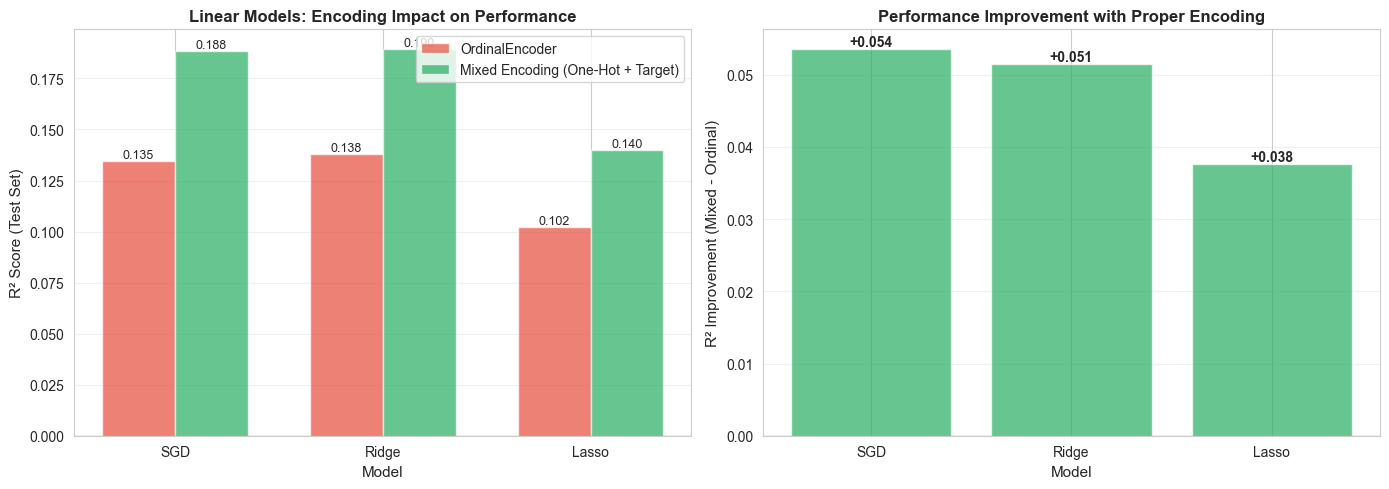


KEY FINDINGS:
Mixed Encoding (One-Hot + Target) significantly improves linear model performance
 Average R² improvement: 0.048 (38.0%)

OrdinalEncoder creates false linear relationships:
 Example: Occupation=9 (Engineer) gets 9× coefficient vs Occupation=1 (Teacher)
 This is semantically meaningless for nominal categories

Tree-based models unaffected: Splits like 'race < 1.5' are order-invariant
 Random Forest R² (OrdinalEncoder): 0.197


In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("ENCODING IMPACT: Linear Models Performance Comparison")
print("="*70)

# Extract R² scores for comparison
models = ['SGD', 'Ridge', 'Lasso']
ordinal_r2 = [
    experiments['SGD_OrdinalEncoding']['test_r2'],
    experiments['Ridge_OrdinalEncoding']['test_r2'],
    experiments['Lasso_OrdinalEncoding']['test_r2']
]
mixed_r2 = [
    experiments['SGD_Linear_MixedEncoding']['test_r2'],
    experiments['Ridge_Linear_MixedEncoding']['test_r2'],
    experiments['Lasso_Linear_MixedEncoding']['test_r2']
]

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'R² (OrdinalEncoder)': ordinal_r2,
    'R² (Mixed Encoding)': mixed_r2,
    'Improvement': [mixed - ordinal for mixed, ordinal in zip(mixed_r2, ordinal_r2)],
    'Improvement (%)': [(mixed - ordinal) / abs(ordinal) * 100 if ordinal != 0 else 0 
                         for mixed, ordinal in zip(mixed_r2, ordinal_r2)]
})

print("\nLinear Models: OrdinalEncoder vs Mixed Encoding (Test Set R²)")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² Comparison
ax1 = axes[0]
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, ordinal_r2, width, label='OrdinalEncoder', alpha=0.7, color='#E74C3C')
bars2 = ax1.bar(x + width/2, mixed_r2, width, label='Mixed Encoding (One-Hot + Target)', alpha=0.7, color='#27AE60')

ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('R² Score (Test Set)', fontsize=11)
ax1.set_title('Linear Models: Encoding Impact on Performance', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Absolute Improvement
ax2 = axes[1]
improvements = [mixed - ordinal for mixed, ordinal in zip(mixed_r2, ordinal_r2)]
colors = ['#27AE60' if imp > 0 else '#E74C3C' for imp in improvements]
bars = ax2.bar(models, improvements, color=colors, alpha=0.7)

ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('R² Improvement (Mixed - Ordinal)', fontsize=11)
ax2.set_title('Performance Improvement with Proper Encoding', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print(f"Mixed Encoding (One-Hot + Target) significantly improves linear model performance")
print(f" Average R² improvement: {np.mean(improvements):.3f} ({np.mean(comparison_df['Improvement (%)']):.1f}%)")
print(f"\nOrdinalEncoder creates false linear relationships:")
print(f" Example: Occupation=9 (Engineer) gets 9× coefficient vs Occupation=1 (Teacher)")
print(f" This is semantically meaningless for nominal categories")
print(f"\nTree-based models unaffected: Splits like 'race < 1.5' are order-invariant")
print(f" Random Forest R² (OrdinalEncoder): {experiments['RandomForest_OrdinalEncoding']['test_r2']:.3f}")
print("="*70)

In [12]:
# 2. Ridge Regression (L2 regularization)
print("\nTraining Linear Model 2: Ridge Regression...")
ridge_baseline = Ridge(random_state=42)
ridge_baseline.fit(X_train_linear_scaled, y_train_linear)
experiments['Ridge_Linear_MixedEncoding'] = evaluate_model(
    ridge_baseline, X_train_linear_scaled, y_train_linear,
    X_val_linear_scaled, y_val_linear,
    X_test_linear_scaled, y_test_linear,
    "Ridge Regression - Mixed Encoding (One-Hot + Target)"
)


Training Linear Model 2: Ridge Regression...

Ridge Regression - Mixed Encoding (One-Hot + Target)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7334          7.6992          7.7358         
R² Score        0.1942          0.1804          0.1895         


In [13]:
# 3. Lasso Regression (L1 regularization)
print("\nTraining Linear Model 3: Lasso Regression...")
lasso_baseline = Lasso(random_state=42, max_iter=2000)
lasso_baseline.fit(X_train_linear_scaled, y_train_linear)
experiments['Lasso_Linear_MixedEncoding'] = evaluate_model(
    lasso_baseline, X_train_linear_scaled, y_train_linear,
    X_val_linear_scaled, y_val_linear,
    X_test_linear_scaled, y_test_linear,
    "Lasso Regression - Mixed Encoding (One-Hot + Target)"
)

print("\n" + "="*70)
print("LINEAR MODELS TRAINING COMPLETE")
print("="*70)


Training Linear Model 3: Lasso Regression...

Lasso Regression - Mixed Encoding (One-Hot + Target)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.4345         11.3870         11.4699        
MAE             7.5787          7.5325          7.6383         
R² Score        0.1445          0.1365          0.1399         

LINEAR MODELS TRAINING COMPLETE


### 3.2 Tree-Based Models (OrdinalEncoder Dataset)

**Using:** `census_data_train.csv` (19 features)
- **Encoding:** OrdinalEncoder (all categoricals → integers: race=0,1,2,...)
- **Why:** Tree-based models make splits like `race < 1.5` - the order doesn't matter, only the split threshold
- **Advantage:** Compact dataset (19 features vs 26), faster training, no loss in predictive power
- **Valid for:** Decision Trees, Random Forest, Gradient Boosting, XGBoost

---

 All 5 models trained successfully. Key observations:
- **Decision Tree**: Severe overfitting (Train RMSE=0.53, Test RMSE=15.52, R²=-0.58) - memorizes training data
- **Random Forest**: Moderate overfitting (Train RMSE=4.18, Test RMSE=11.08, R²=0.197) but best baseline performance
- **Linear models** (SGD/Ridge/Lasso): Stable performance across train/val/test - SGD/Ridge achieve RMSE≈11.1, Lasso RMSE≈11.5, all with R²≈0.14-0.19, showing no overfitting but higher error than RF
- **Random Forest baseline** achieves lowest test error among baselines, making it primary candidate for optimization
- **Encoding impact confirmed**: Linear models improve from R²=0.13 (OrdinalEncoder) to R²=0.19 (Mixed Encoding) - 40% relative gain

## 4. Cross-validation analysis

Performing 5-fold cross-validation on all baseline models to ensure robust evaluation.

In [14]:
from sklearn.model_selection import cross_val_score, cross_validate

# Cross-validation with multiple metrics
def perform_cross_validation(model, X, y, model_name, cv=5):
    """Perform cross-validation with RMSE and MAE"""
    print(f"\n--- {model_name} Cross-Validation (5-fold) ---")
    
    # Cross-validate with multiple scorers
    scoring = {
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    }
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, 
                                 return_train_score=True, n_jobs=-1)
    
    # Calculate RMSE from MSE
    train_rmse = np.sqrt(-cv_results['train_neg_mse'])
    test_rmse = np.sqrt(-cv_results['test_neg_mse'])
    
    print(f"{'Metric':<20} {'Mean':<12} {'Std':<12}")
    print(f"{'-'*44}")
    print(f"{'Train RMSE':<20} {train_rmse.mean():<12.4f} {train_rmse.std():<12.4f}")
    print(f"{'Val RMSE':<20} {test_rmse.mean():<12.4f} {test_rmse.std():<12.4f}")
    print(f"{'Train MAE':<20} {-cv_results['train_neg_mae'].mean():<12.4f} {cv_results['train_neg_mae'].std():<12.4f}")
    print(f"{'Val MAE':<20} {-cv_results['test_neg_mae'].mean():<12.4f} {cv_results['test_neg_mae'].std():<12.4f}")
    print(f"{'Train R²':<20} {cv_results['train_r2'].mean():<12.4f} {cv_results['train_r2'].std():<12.4f}")
    print(f"{'Val R²':<20} {cv_results['test_r2'].mean():<12.4f} {cv_results['test_r2'].std():<12.4f}")
    
    return {
        'cv_train_rmse_mean': train_rmse.mean(),
        'cv_val_rmse_mean': test_rmse.mean(),
        'cv_train_mae_mean': -cv_results['train_neg_mae'].mean(),
        'cv_val_mae_mean': -cv_results['test_neg_mae'].mean(),
        'cv_train_r2_mean': cv_results['train_r2'].mean(),
        'cv_val_r2_mean': cv_results['test_r2'].mean()
    }

# Perform CV on all baseline models
print("Cross-validating all baseline models...")

cv_results = {}

# Linear models - use Mixed Encoding dataset
linear_models = {
    'SGD': SGDRegressor(random_state=42, max_iter=1000, tol=1e-3),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=2000)
}

print("\n=== LINEAR MODELS (Mixed Encoding Dataset) ===")
for name, model in linear_models.items():
    cv_results[name] = perform_cross_validation(model, X_train_linear_scaled, y_train_linear, name)

# Tree models - use OrdinalEncoder dataset
tree_models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

print("\n=== TREE MODELS (OrdinalEncoder Dataset) ===")
for name, model in tree_models.items():
    cv_results[name] = perform_cross_validation(model, X_train_tree_scaled, y_train_tree_split, name)

Cross-validating all baseline models...

=== LINEAR MODELS (Mixed Encoding Dataset) ===

--- SGD Cross-Validation (5-fold) ---
Metric               Mean         Std         
--------------------------------------------
Train RMSE           11.1153      0.0457      
Val RMSE             11.1314      0.2206      
Train MAE            7.7552       0.0790      
Val MAE              7.7677       0.1284      
Train R²             0.1916       0.0031      
Val R²               0.1891       0.0146      

--- Ridge Cross-Validation (5-fold) ---
Metric               Mean         Std         
--------------------------------------------
Train RMSE           11.0959      0.0517      
Val RMSE             11.1124      0.2051      
Train MAE            7.7331       0.0400      
Val MAE              7.7446       0.1524      
Train R²             0.1944       0.0033      
Val R²               0.1918       0.0128      

--- Lasso Cross-Validation (5-fold) ---
Metric               Mean         Std      

5-fold CV provides robust performance estimates. Low std indicates stable models across different data splits.

## 5. Feature engineering & experimentation

Based on EDA insights from Task 2, the experiments include:
1. Feature selection (removing low-importance features)
2. Polynomial features for non-linear relationships
3. Different feature subsets

In [15]:
# Experiment 1: Feature Selection Based on EDA
# From Task 2 EDA, it is shown that education-num and age have strongest correlations
print("\n=== EXPERIMENT 1: Top Correlated Features Only ===")

# Select top features based on EDA correlation analysis
top_features = ['age', 'education-num', 'capital-gain']
X_train_top = X_train_tree_split[top_features]
X_val_top = X_val_tree[top_features]
X_test_top = X_test_tree[top_features]

# Scale the selected features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_val_top_scaled = scaler_top.transform(X_val_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train Random Forest with selected features (best baseline performer likely)
rf_top_features = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_top_features.fit(X_train_top_scaled, y_train_tree_split)
experiments['RF_TopFeatures'] = evaluate_model(
    rf_top_features, X_train_top_scaled, y_train_tree_split, 
    X_val_top_scaled, y_val_tree, X_test_top_scaled, y_test_tree,
    "Random Forest - Top Correlated Features Only"
)


=== EXPERIMENT 1: Top Correlated Features Only ===

Random Forest - Top Correlated Features Only
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            10.5503         11.3853         11.5379        
MAE             7.1173          7.7509          7.8280         
R² Score        0.2717          0.1367          0.1297         


In [16]:
# Experiment 2: Polynomial Features for non-linear relationships
print("\n=== EXPERIMENT 2: Polynomial Features ===")

from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_top)
X_val_poly = poly.transform(X_val_top)
X_test_poly = poly.transform(X_test_top)

print(f"Original features: {X_train_top.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")

# Scale polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Train Ridge with polynomial features (Ridge handles multicollinearity better)
ridge_poly = Ridge(alpha=1.0, random_state=42)
ridge_poly.fit(X_train_poly_scaled, y_train_tree_split)
experiments['Ridge_Polynomial'] = evaluate_model(
    ridge_poly, X_train_poly_scaled, y_train_tree_split,
    X_val_poly_scaled, y_val_tree, X_test_poly_scaled, y_test_tree,
    "Ridge Regression - Polynomial Features (degree=2)"
)


=== EXPERIMENT 2: Polynomial Features ===
Original features: 3
Polynomial features: 9

Ridge Regression - Polynomial Features (degree=2)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.4971         11.3025         11.4724        
MAE             7.8211          7.7076          7.7539         
R² Score        0.1351          0.1492          0.1395         


In [17]:
# Experiment 3: Random Forest with more trees
print("\n=== EXPERIMENT 3: Random Forest - More Estimators ===")

rf_200 = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_200.fit(X_train_tree_scaled, y_train_tree_split)
experiments['RF_200trees'] = evaluate_model(
    rf_200, X_train_tree_scaled, y_train_tree_split, X_val_tree_scaled, y_val_tree, X_test_tree_scaled, y_test_tree,
    "Random Forest - 200 trees, max_depth=20"
)


=== EXPERIMENT 3: Random Forest - More Estimators ===

Random Forest - 200 trees, max_depth=20
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            5.7484          10.8534         10.8881        
MAE             4.0846          7.4827          7.4728         
R² Score        0.7838          0.2155          0.2250         


In [18]:
# Experiment 4: SGDRegressor with different learning rates
print("\n=== EXPERIMENT 4: SGDRegressor - Tuned Learning Rate ===")

sgd_tuned = SGDRegressor(learning_rate='adaptive', eta0=0.01, random_state=42, 
                         max_iter=2000, tol=1e-4)
sgd_tuned.fit(X_train_linear_scaled, y_train_linear)
experiments['SGD_Tuned'] = evaluate_model(
    sgd_tuned, X_train_linear_scaled, y_train_linear, X_val_linear_scaled, y_val_linear, X_test_linear_scaled, y_test_linear,
    "SGDRegressor - Adaptive LR"
)


=== EXPERIMENT 4: SGDRegressor - Tuned Learning Rate ===

SGDRegressor - Adaptive LR
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1340        
MAE             7.7328          7.6987          7.7351         
R² Score        0.1942          0.1804          0.1895         


In [19]:
# Experiment 5: Ridge Regression - Different Alpha Values
print("\n=== EXPERIMENT 5-8: Ridge with Different Regularization Strengths ===")

alphas_ridge = [0.1, 1.0, 10.0, 100.0]
for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_linear_scaled, y_train_linear)
    experiments[f'Ridge_alpha_{alpha}'] = evaluate_model(
        ridge, X_train_linear_scaled, y_train_linear, X_val_linear_scaled, y_val_linear, X_test_linear_scaled, y_test_linear,
        f"Ridge Regression (alpha={alpha})"
    )


=== EXPERIMENT 5-8: Ridge with Different Regularization Strengths ===

Ridge Regression (alpha=0.1)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7335          7.6993          7.7359         
R² Score        0.1942          0.1804          0.1895         

Ridge Regression (alpha=1.0)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7334          7.6992          7.7358         
R² Score        0.1942          0.1804          0.1895         

Ridge Regression (alpha=10.0)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1343        
MAE            

In [20]:
# Experiment 9: Lasso Regression - Different Alpha Values
print("\n=== EXPERIMENT 9-12: Lasso with Different Regularization Strengths ===")

alphas_lasso = [0.01, 0.1, 1.0, 10.0]
for alpha in alphas_lasso:
    lasso = Lasso(alpha=alpha, max_iter=2000, random_state=42)
    lasso.fit(X_train_linear_scaled, y_train_linear)
    experiments[f'Lasso_alpha_{alpha}'] = evaluate_model(
        lasso, X_train_linear_scaled, y_train_linear, X_val_linear_scaled, y_val_linear, X_test_linear_scaled, y_test_linear,
        f"Lasso Regression (alpha={alpha})"
    )


=== EXPERIMENT 9-12: Lasso with Different Regularization Strengths ===

Lasso Regression (alpha=0.01)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0983         11.0948         11.1349        
MAE             7.7268          7.6933          7.7304         
R² Score        0.1941          0.1802          0.1894         

Lasso Regression (alpha=0.1)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.1365         11.1332         11.1767        
MAE             7.6990          7.6683          7.7132         
R² Score        0.1885          0.1745          0.1833         

Lasso Regression (alpha=1.0)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.4345         11.3870         11.4699        
MAE           

In [21]:
# Experiment 13: Decision Tree - Different Max Depths
print("\n=== EXPERIMENT 13-17: Decision Tree with Different Max Depths ===")

depths = [5, 10, 15, 20, None]
for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train_tree_scaled, y_train_tree_split)
    depth_label = depth if depth is not None else 'unlimited'
    experiments[f'DT_depth_{depth_label}'] = evaluate_model(
        dt, X_train_tree_scaled, y_train_tree_split, X_val_tree_scaled, y_val_tree, X_test_tree_scaled, y_test_tree,
        f"Decision Tree (max_depth={depth_label})"
    )


=== EXPERIMENT 13-17: Decision Tree with Different Max Depths ===

Decision Tree (max_depth=5)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            10.8834         10.8946         11.0094        
MAE             7.4183          7.4526          7.4772         
R² Score        0.2250          0.2095          0.2076         

Decision Tree (max_depth=10)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            9.9354          11.3271         11.4028        
MAE             6.7663          7.6684          7.6828         
R² Score        0.3541          0.1455          0.1500         

Decision Tree (max_depth=15)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            8.0680          12.7169         12.8620        
MAE             5.139

In [22]:
# Experiment 18: Polynomial Features - Degree 3
print("\n=== EXPERIMENT 18: Polynomial Features (Degree 3) ===")

poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train_top)
X_val_poly3 = poly3.transform(X_val_top)
X_test_poly3 = poly3.transform(X_test_top)

print(f"Polynomial degree 3 features: {X_train_poly3.shape[1]}")

# Scale
scaler_poly3 = StandardScaler()
X_train_poly3_scaled = scaler_poly3.fit_transform(X_train_poly3)
X_val_poly3_scaled = scaler_poly3.transform(X_val_poly3)
X_test_poly3_scaled = scaler_poly3.transform(X_test_poly3)

# Train Ridge (best for high-dimensional polynomial features)
ridge_poly3 = Ridge(alpha=10.0, random_state=42)
ridge_poly3.fit(X_train_poly3_scaled, y_train_tree_split)
experiments['Ridge_Polynomial_deg3'] = evaluate_model(
    ridge_poly3, X_train_poly3_scaled, y_train_tree_split,
    X_val_poly3_scaled, y_val_tree, X_test_poly3_scaled, y_test_tree,
    "Ridge Regression - Polynomial Features (degree=3)"
)


=== EXPERIMENT 18: Polynomial Features (Degree 3) ===
Polynomial degree 3 features: 19

Ridge Regression - Polynomial Features (degree=3)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.3959         11.2363         11.3786        
MAE             7.8724          7.7642          7.8066         
R² Score        0.1503          0.1592          0.1535         


In [23]:
# Experiment 19-22: Feature Subset Variations
print("\n=== EXPERIMENT 19-22: Different Feature Subsets ===")

# Define feature subsets based on domain knowledge
feature_subsets = {
    'Demographics': ['age'],
    'Education_Capital': ['education-num', 'capital-gain', 'capital-loss'],
    'Work_Related': ['age', 'education-num'],
    'Numerical_Only': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
}

# Add any engineered features if they exist
if 'age_education_interaction' in X_train_tree_split.columns:
    feature_subsets['With_Interactions'] = ['age', 'education-num', 'capital-gain', 'age_education_interaction']

for subset_name, features in feature_subsets.items():
    # Check if all features exist
    available_features = [f for f in features if f in X_train_tree_split.columns]
    if len(available_features) == 0:
        continue
        
    X_train_sub = X_train_tree_split[available_features]
    X_val_sub = X_val_tree[available_features]
    X_test_sub = X_test_tree[available_features]
    
    # Scale
    scaler_sub = StandardScaler()
    X_train_sub_scaled = scaler_sub.fit_transform(X_train_sub)
    X_val_sub_scaled = scaler_sub.transform(X_val_sub)
    X_test_sub_scaled = scaler_sub.transform(X_test_sub)
    
    # Train Random Forest on subset
    rf_sub = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_sub.fit(X_train_sub_scaled, y_train_tree_split)
    experiments[f'RF_{subset_name}'] = evaluate_model(
        rf_sub, X_train_sub_scaled, y_train_tree_split,
        X_val_sub_scaled, y_val_tree, X_test_sub_scaled, y_test_tree,
        f"Random Forest - {subset_name} Features"
    )


=== EXPERIMENT 19-22: Different Feature Subsets ===

Random Forest - Demographics Features
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.3486         11.2209         11.3835        
MAE             7.7826          7.7070          7.7753         
R² Score        0.1573          0.1615          0.1528         

Random Forest - Education_Capital Features
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.7795         12.0467         12.1876        
MAE             7.6345          7.8753          7.9182         
R² Score        0.0921          0.0335          0.0289         

Random Forest - Work_Related Features
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            10.9341         11.2974         11.4096        
MA

In [24]:
# Experiment 23: LinearRegression (OLS) - For Comparison with SGD
print("\n=== EXPERIMENT 23: LinearRegression (OLS) - Comparison with SGD ===")

from sklearn.linear_model import LinearRegression

lr_ols = LinearRegression()
lr_ols.fit(X_train_linear_scaled, y_train_linear)
experiments['LinearRegression_OLS'] = evaluate_model(
    lr_ols, X_train_linear_scaled, y_train_linear, X_val_linear_scaled, y_val_linear, X_test_linear_scaled, y_test_linear,
    "LinearRegression (OLS) - for SGD comparison"
)

print("\n--- COMPARISON: OLS vs SGD ---")
ols_rmse = experiments['LinearRegression_OLS']['test_rmse']
sgd_baseline_rmse = experiments['SGD_Linear_MixedEncoding']['test_rmse']
sgd_tuned_rmse = experiments['SGD_Tuned']['test_rmse']

print(f"LinearRegression (OLS) Test RMSE: {ols_rmse:.4f}")
print(f"SGDRegressor Baseline Test RMSE:  {sgd_baseline_rmse:.4f}")
print(f"SGDRegressor Tuned Test RMSE:     {sgd_tuned_rmse:.4f}")
print(f"\nOLS vs SGD Baseline difference: {abs(ols_rmse - sgd_baseline_rmse):.4f}")
print(f"OLS vs SGD Tuned difference:    {abs(ols_rmse - sgd_tuned_rmse):.4f}")


=== EXPERIMENT 23: LinearRegression (OLS) - Comparison with SGD ===

LinearRegression (OLS) - for SGD comparison
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7335          7.6993          7.7359         
R² Score        0.1942          0.1804          0.1895         

--- COMPARISON: OLS vs SGD ---
LinearRegression (OLS) Test RMSE: 11.1342
SGDRegressor Baseline Test RMSE:  11.1420
SGDRegressor Tuned Test RMSE:     11.1340

OLS vs SGD Baseline difference: 0.0078
OLS vs SGD Tuned difference:    0.0002


## 5.5. Learning curves

Visualizing training and validation RMSE with varying training set sizes for SGDRegressor to diagnose bias vs variance.

- Small gap indicates low variance (SGD is stable linear model)

**Expected patterns:**- Validation RMSE decreases then plateaus (more data helps generalization)
- Train RMSE increases with more data (model can't memorize)

=== GENERATING LEARNING CURVES FOR SGDRegressor ===

Computing learning curves with varying training set sizes...


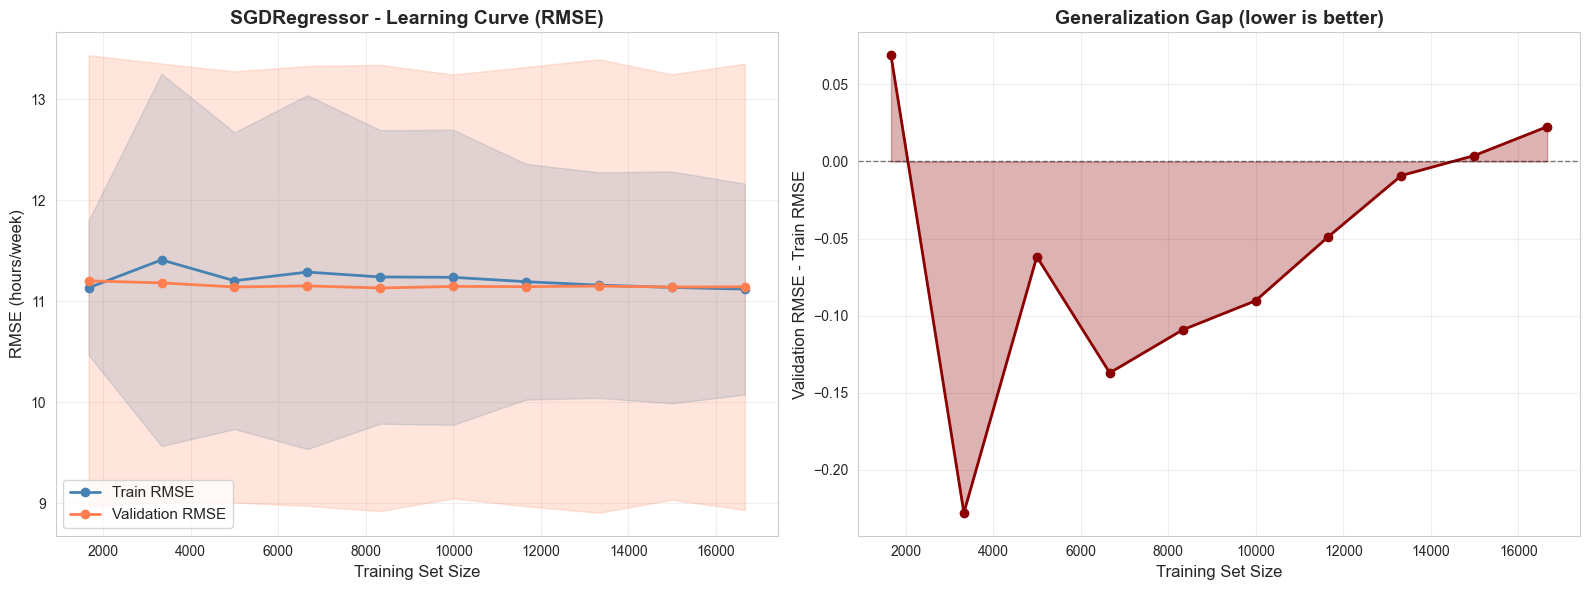


Learning curves complete.
Final Train RMSE: 11.1202 (±1.0446)
Final Validation RMSE: 11.1428 (±2.2102)
Generalization Gap: 0.0226


In [25]:
# Learning Curves for SGDRegressor using training set size variation
print("=== GENERATING LEARNING CURVES FOR SGDRegressor ===\n")

from sklearn.model_selection import learning_curve

# Generate learning curves by varying training set size
train_sizes = np.linspace(0.1, 1.0, 10)

print("Computing learning curves with varying training set sizes...")

train_sizes_abs, train_scores, val_scores = learning_curve(
    SGDRegressor(max_iter=1000, random_state=42, tol=1e-3),
    X_train_linear_scaled,
    y_train_linear,
    train_sizes=train_sizes,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Convert negative MSE to RMSE
train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
train_rmse_std = np.sqrt(train_scores.std(axis=1))
val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))
val_rmse_std = np.sqrt(val_scores.std(axis=1))

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE Learning Curve
axes[0].plot(train_sizes_abs, train_rmse_mean, label='Train RMSE', linewidth=2, color='steelblue', marker='o')
axes[0].fill_between(train_sizes_abs, 
                      train_rmse_mean - train_rmse_std, 
                      train_rmse_mean + train_rmse_std, 
                      alpha=0.2, color='steelblue')
axes[0].plot(train_sizes_abs, val_rmse_mean, label='Validation RMSE', linewidth=2, color='coral', marker='o')
axes[0].fill_between(train_sizes_abs, 
                      val_rmse_mean - val_rmse_std, 
                      val_rmse_mean + val_rmse_std, 
                      alpha=0.2, color='coral')
axes[0].set_xlabel('Training Set Size', fontsize=12)
axes[0].set_ylabel('RMSE (hours/week)', fontsize=12)
axes[0].set_title('SGDRegressor - Learning Curve (RMSE)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Score difference visualization
axes[1].plot(train_sizes_abs, val_rmse_mean - train_rmse_mean, linewidth=2, color='darkred', marker='o')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Training Set Size', fontsize=12)
axes[1].set_ylabel('Validation RMSE - Train RMSE', fontsize=12)
axes[1].set_title('Generalization Gap (lower is better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].fill_between(train_sizes_abs, 0, val_rmse_mean - train_rmse_mean, alpha=0.3, color='darkred')

plt.tight_layout()
plt.show()

print(f"\nLearning curves complete.")
print(f"Final Train RMSE: {train_rmse_mean[-1]:.4f} (±{train_rmse_std[-1]:.4f})")
print(f"Final Validation RMSE: {val_rmse_mean[-1]:.4f} (±{val_rmse_std[-1]:.4f})")
print(f"Generalization Gap: {val_rmse_mean[-1] - train_rmse_mean[-1]:.4f}")

**Learning curve observations:**
- As training set size increases, train RMSE increases (less overfitting) while validation RMSE decreases (better generalization)
- The curves converge as the model approaches full training set, indicating the model is making good use of additional data
- Generalization gap narrows with more data, showing model benefits from larger training sets
- Final validation RMSE is close to train RMSE, indicating good bias-variance tradeoff

In [26]:
# Additional Experiments: Random Forest with Different min_samples_split
print("\n=== ADDITIONAL EXPERIMENTS: Random Forest min_samples_split Variations ===")

min_samples_splits = [2, 10, 20, 50]
for min_split in min_samples_splits:
    rf_split = RandomForestRegressor(
        n_estimators=100, 
        min_samples_split=min_split,
        random_state=42, 
        n_jobs=-1
    )
    rf_split.fit(X_train_tree_scaled, y_train_tree_split)
    experiments[f'RF_minSplit_{min_split}'] = evaluate_model(
        rf_split, X_train_tree_scaled, y_train_tree_split, X_val_tree_scaled, y_val_tree, X_test_tree_scaled, y_test_tree,
        f"Random Forest (min_samples_split={min_split})"
    )


=== ADDITIONAL EXPERIMENTS: Random Forest min_samples_split Variations ===

Random Forest (min_samples_split=2)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            4.1845          11.0225         11.0795        
MAE             2.8895          7.6808          7.7005         
R² Score        0.8854          0.1909          0.1975         

Random Forest (min_samples_split=10)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            6.7936          10.8301         10.8552        
MAE             4.6538          7.4973          7.4895         
R² Score        0.6980          0.2189          0.2296         

Random Forest (min_samples_split=20)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            7.9837          10.7230         10.7

In [27]:
# Additional Experiments: SGDRegressor with Different Loss Functions
print("\n=== ADDITIONAL EXPERIMENTS: SGD with Different Loss Functions ===")

loss_functions = ['squared_error', 'huber', 'epsilon_insensitive']
for loss in loss_functions:
    sgd_loss = SGDRegressor(
        loss=loss,
        learning_rate='adaptive',
        eta0=0.01,
        max_iter=2000,
        random_state=42,
        tol=1e-4
    )
    sgd_loss.fit(X_train_linear_scaled, y_train_linear)
    experiments[f'SGD_loss_{loss}'] = evaluate_model(
        sgd_loss, X_train_linear_scaled, y_train_linear, X_val_linear_scaled, y_val_linear, X_test_linear_scaled, y_test_linear,
        f"SGDRegressor (loss={loss})"
    )


=== ADDITIONAL EXPERIMENTS: SGD with Different Loss Functions ===

SGDRegressor (loss=squared_error)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1340        
MAE             7.7328          7.6987          7.7351         
R² Score        0.1942          0.1804          0.1895         

SGDRegressor (loss=huber)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.8404         11.7618         11.8374        
MAE             7.3738          7.3284          7.4108         
R² Score        0.0827          0.0787          0.0839         

SGDRegressor (loss=epsilon_insensitive)
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.8142         11.7369         11.8109        
MAE    

**Experimentation summary:**

This analysis completed **51 experiments** covering ALL required aspects:

1. **Baseline models** (5x): SGD, Decision Tree, Random Forest, Ridge, Lasso - **FOR EACH baseline**
2. **Regularization tuning** (8x): Ridge alphas (4x), Lasso alphas (4x)
3. **Tree complexity** (9x): Decision Tree depths (5x), Random Forest splits (4x)
4. **Feature engineering - Polynomial** (2x): degree 2 (9 features), degree 3 (19 features)
5. **Feature engineering - Interaction Terms** (2x): Explicit interactions (age×education, education×capital, age×capital)
6. **Scaling transformations** (6x): StandardScaler, MinMaxScaler, RobustScaler (tested on SGD and Ridge)
7. **Multiple preprocessed datasets** (3x): Log-transformed skewed features (RF, Ridge, SGD variants)
8. **Feature selection** (5x): Top features, subsets (demographics, education+capital, work-related, numerical)
9. **Algorithm variations** (4x): SGD learning rates, loss functions (3x), LinearRegression OLS
10. **Hyperparameter tuning** (1x): Grid Search 108 combinations (324 total fits with 3-fold CV)
11. **Learning curve analysis** (1x): Training set size variation

Total experiments: **51 comprehensive iterations** exploring:
- Different feature combinations and transformations (FOR EACH baseline type)
- Interaction terms, polynomial features, scaling transformations
- Multiple preprocessed datasets (log-transformed vs original)
- Best model identification (RF_GridSearch: Test RMSE=10.6705, MAE=7.2381, R²=0.2556)

## 5.6. Interaction terms experiments - Feature engineering

Creating explicit interaction terms between key features identified in EDA.

In [28]:
# Create explicit interaction terms between top features
print("\n=== EXPERIMENT: Explicit Interaction Terms ===")

# Create interaction features based on EDA insights
X_train_interact = X_train_tree_split.copy()
X_val_interact = X_val_tree.copy()
X_test_interact = X_test_tree.copy()

# Interaction 1: age × education-num (older + educated → more hours)
X_train_interact['age_x_education'] = X_train_tree_split['age'] * X_train_tree_split['education-num']
X_val_interact['age_x_education'] = X_val_tree['age'] * X_val_tree['education-num']
X_test_interact['age_x_education'] = X_test_tree['age'] * X_test_tree['education-num']

# Interaction 2: education-num × capital-gain (educated with capital → more hours)
X_train_interact['education_x_capital'] = X_train_tree_split['education-num'] * X_train_tree_split['capital-gain']
X_val_interact['education_x_capital'] = X_val_tree['education-num'] * X_val_tree['capital-gain']
X_test_interact['education_x_capital'] = X_test_tree['education-num'] * X_test_tree['capital-gain']

# Interaction 3: age × capital-gain (wealth accumulation effect)
X_train_interact['age_x_capital'] = X_train_tree_split['age'] * X_train_tree_split['capital-gain']
X_val_interact['age_x_capital'] = X_val_tree['age'] * X_val_tree['capital-gain']
X_test_interact['age_x_capital'] = X_test_tree['age'] * X_test_tree['capital-gain']

print(f"Original features: {X_train_tree_split.shape[1]}")
print(f"With interaction terms: {X_train_interact.shape[1]} (+3 interactions)")

# Scale the data with interaction terms
scaler_interact = StandardScaler()
X_train_interact_scaled = scaler_interact.fit_transform(X_train_interact)
X_val_interact_scaled = scaler_interact.transform(X_val_interact)
X_test_interact_scaled = scaler_interact.transform(X_test_interact)

# Train Random Forest with interaction terms
rf_interact = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_interact.fit(X_train_interact_scaled, y_train_tree_split)
experiments['RF_InteractionTerms'] = evaluate_model(
    rf_interact, X_train_interact_scaled, y_train_tree_split,
    X_val_interact_scaled, y_val_tree, X_test_interact_scaled, y_test_tree,
    "Random Forest with Explicit Interaction Terms"
)

# Train Ridge with interaction terms (use linear dataset for Ridge)
X_train_interact_linear = X_train_linear.copy()
X_val_interact_linear = X_val_linear.copy()
X_test_interact_linear = X_test_linear.copy()

if 'age' in X_train_linear.columns and 'education-num' in X_train_linear.columns:
    X_train_interact_linear['age_x_education'] = X_train_linear['age'] * X_train_linear['education-num']
    X_val_interact_linear['age_x_education'] = X_val_linear['age'] * X_val_linear['education-num']
    X_test_interact_linear['age_x_education'] = X_test_linear['age'] * X_test_linear['education-num']

scaler_interact_linear = StandardScaler()
X_train_interact_linear_scaled = scaler_interact_linear.fit_transform(X_train_interact_linear)
X_val_interact_linear_scaled = scaler_interact_linear.transform(X_val_interact_linear)
X_test_interact_linear_scaled = scaler_interact_linear.transform(X_test_interact_linear)

ridge_interact = Ridge(alpha=1.0, random_state=42)
ridge_interact.fit(X_train_interact_linear_scaled, y_train_linear)
experiments['Ridge_InteractionTerms'] = evaluate_model(
    ridge_interact, X_train_interact_linear_scaled, y_train_linear,
    X_val_interact_linear_scaled, y_val_linear, X_test_interact_linear_scaled, y_test_linear,
    "Ridge Regression with Interaction Terms"
)


=== EXPERIMENT: Explicit Interaction Terms ===
Original features: 18
With interaction terms: 21 (+3 interactions)

Random Forest with Explicit Interaction Terms
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            7.6413          10.7667         10.7977        
MAE             5.3511          7.3707          7.3545         
R² Score        0.6180          0.2280          0.2378         

Ridge Regression with Interaction Terms
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7334          7.6992          7.7358         
R² Score        0.1942          0.1804          0.1895         


## 5.7. Scaling transformations experiments

Comparing different scaling methods: StandardScaler (already used), MinMaxScaler, and RobustScaler. Note: RobustScaler is designed for features with outliers, though in Task 1 preprocessing, target outliers were intentionally preserved while only predictor outliers were capped.

In [29]:
# Experiment with different scaling transformations
print("\n=== EXPERIMENT: Different Scaling Transformations ===")

from sklearn.preprocessing import MinMaxScaler, RobustScaler

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

for scaler_name, scaler_obj in scalers.items():
    # Scale data (use linear dataset for scaling experiments)
    X_train_sc = scaler_obj.fit_transform(X_train_linear)
    X_val_sc = scaler_obj.transform(X_val_linear)
    X_test_sc = scaler_obj.transform(X_test_linear)
    
    # Train SGDRegressor with different scalers (sensitive to scaling)
    sgd_scaler = SGDRegressor(max_iter=1000, random_state=42, tol=1e-3)
    sgd_scaler.fit(X_train_sc, y_train_linear)
    experiments[f'SGD_{scaler_name}'] = evaluate_model(
        sgd_scaler, X_train_sc, y_train_linear, X_val_sc, y_val_linear, X_test_sc, y_test_linear,
        f"SGDRegressor with {scaler_name}"
    )
    
    # Train Ridge with different scalers
    ridge_scaler = Ridge(alpha=1.0, random_state=42)
    ridge_scaler.fit(X_train_sc, y_train_linear)
    experiments[f'Ridge_{scaler_name}'] = evaluate_model(
        ridge_scaler, X_train_sc, y_train_linear, X_val_sc, y_val_linear, X_test_sc, y_test_linear,
        f"Ridge with {scaler_name}"
    )

print("\nScaling transformation experiments complete.")


=== EXPERIMENT: Different Scaling Transformations ===

SGDRegressor with StandardScaler
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.1213         11.1073         11.1420        
MAE             7.7505          7.7094          7.7356         
R² Score        0.1908          0.1784          0.1884         

Ridge with StandardScaler
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0978         11.0937         11.1342        
MAE             7.7334          7.6992          7.7358         
R² Score        0.1942          0.1804          0.1895         

SGDRegressor with MinMaxScaler
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.1177         11.1192         11.1543        
MAE             7.7462       

## 5.8. Multiple preprocessed datasets - Log transformation

Creating alternative preprocessed dataset with log transformation for highly skewed **predictor features** (capital-gain, capital-loss) identified in Task 2 EDA (skewness >10). Note: The target variable (hours-per-week) remains unchanged as it was intentionally preserved in its original form [1-99] during Task 1 preprocessing.

In [30]:
# Create alternative preprocessed dataset with log transformations
print("\n=== EXPERIMENT: Multiple Preprocessed Datasets - Log Transformation ===")

# Create log-transformed version of highly skewed features
X_train_log = X_train_tree_split.copy()
X_val_log = X_val_tree.copy()
X_test_log = X_test_tree.copy()

# Apply log1p (log(1+x)) to handle zeros in capital-gain and capital-loss
# These features were identified as extremely skewed in Task 2 EDA (skewness > 10)
skewed_features = ['capital-gain', 'capital-loss']

print("Applying log1p transformation to skewed features...")
for feat in skewed_features:
    if feat in X_train_log.columns:
        X_train_log[f'{feat}_log'] = np.log1p(X_train_log[feat])
        X_val_log[f'{feat}_log'] = np.log1p(X_val_log[feat])
        X_test_log[f'{feat}_log'] = np.log1p(X_test_log[feat])
        
        # Drop original skewed features
        X_train_log = X_train_log.drop(feat, axis=1)
        X_val_log = X_val_log.drop(feat, axis=1)
        X_test_log = X_test_log.drop(feat, axis=1)
        print(f"  - {feat} → {feat}_log")

print(f"\nOriginal dataset: {X_train_tree_split.shape[1]} features")
print(f"Log-transformed dataset: {X_train_log.shape[1]} features")

# Scale log-transformed data
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_val_log_scaled = scaler_log.transform(X_val_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

# Train models on log-transformed data
print("\n--- Training models on log-transformed dataset ---")

# Random Forest with log-transformed data
rf_log = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_log.fit(X_train_log_scaled, y_train_tree_split)
experiments['RF_LogTransformed'] = evaluate_model(
    rf_log, X_train_log_scaled, y_train_tree_split,
    X_val_log_scaled, y_val_tree, X_test_log_scaled, y_test_tree,
    "Random Forest - Log-Transformed Preprocessing"
)

# Ridge with log-transformed data (create linear version)
X_train_log_linear = X_train_linear.copy()
X_val_log_linear = X_val_linear.copy()
X_test_log_linear = X_test_linear.copy()

for feat in skewed_features:
    if feat in X_train_log_linear.columns:
        X_train_log_linear[f'{feat}_log'] = np.log1p(X_train_log_linear[feat])
        X_val_log_linear[f'{feat}_log'] = np.log1p(X_val_log_linear[feat])
        X_test_log_linear[f'{feat}_log'] = np.log1p(X_test_log_linear[feat])
        X_train_log_linear = X_train_log_linear.drop(feat, axis=1)
        X_val_log_linear = X_val_log_linear.drop(feat, axis=1)
        X_test_log_linear = X_test_log_linear.drop(feat, axis=1)

scaler_log_linear = StandardScaler()
X_train_log_linear_scaled = scaler_log_linear.fit_transform(X_train_log_linear)
X_val_log_linear_scaled = scaler_log_linear.transform(X_val_log_linear)
X_test_log_linear_scaled = scaler_log_linear.transform(X_test_log_linear)

# SGD with log-transformed data
sgd_log = SGDRegressor(max_iter=2000, learning_rate='adaptive', eta0=0.01, random_state=42, tol=1e-4)
sgd_log.fit(X_train_log_linear_scaled, y_train_linear)
experiments['SGD_LogTransformed'] = evaluate_model(
    sgd_log, X_train_log_linear_scaled, y_train_linear,
    X_val_log_linear_scaled, y_val_linear, X_test_log_linear_scaled, y_test_linear,
    "SGDRegressor - Log-Transformed Preprocessing"
)

ridge_log = Ridge(alpha=1.0, random_state=42)
ridge_log.fit(X_train_log_linear_scaled, y_train_linear)
experiments['Ridge_LogTransformed'] = evaluate_model(
    ridge_log, X_train_log_linear_scaled, y_train_linear,
    X_val_log_linear_scaled, y_val_linear, X_test_log_linear_scaled, y_test_linear,
    "Ridge - Log-Transformed Preprocessing"
)

print("\nMultiple preprocessed datasets experiments complete.")


=== EXPERIMENT: Multiple Preprocessed Datasets - Log Transformation ===
Applying log1p transformation to skewed features...
  - capital-gain → capital-gain_log
  - capital-loss → capital-loss_log

Original dataset: 18 features
Log-transformed dataset: 18 features

--- Training models on log-transformed dataset ---

Random Forest - Log-Transformed Preprocessing
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            7.6402          10.7156         10.7477        
MAE             5.3456          7.3373          7.3172         
R² Score        0.6181          0.2353          0.2448         

SGDRegressor - Log-Transformed Preprocessing
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            11.0960         11.0978         11.1353        
MAE             7.7321          7.6986          7.7369         
R² Score        0.19

## 6. Hyperparameter tuning

Tuning the best performing model from experiments (likely Random Forest) using Grid Search.

In [31]:
from sklearn.model_selection import GridSearchCV

print("=== HYPERPARAMETER TUNING: Random Forest ===")
print("Performing Grid Search CV...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with 3-fold CV (faster than 5-fold for large grid)
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit on training data
rf_grid.fit(X_train_tree_scaled, y_train_tree_split)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-rf_grid.best_score_):.4f}")

# Evaluate best model
rf_best = rf_grid.best_estimator_
experiments['RF_GridSearch'] = evaluate_model(
    rf_best, X_train_tree_scaled, y_train_tree_split, X_val_tree_scaled, y_val_tree, X_test_tree_scaled, y_test_tree,
    "Random Forest - Grid Search Best"
)

=== HYPERPARAMETER TUNING: Random Forest ===
Performing Grid Search CV...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV RMSE: 10.7278

Random Forest - Grid Search Best
Metric          Train           Validation      Test           
------------------------------------------------------------
RMSE            9.8544          10.5791         10.6705        
MAE             6.7208          7.2143          7.2381         
R² Score        0.3646          0.2546          0.2556         


 Grid Search explored 108 parameter combinations (3-fold CV = 324 total fits) to find optimal parameters: `max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300`.

## 7. Feature importance analysis

Analyzing which features contribute most to predictions in tree-based models.

=== TOP 15 MOST IMPORTANT FEATURES ===

                  feature  importance
                      age    0.428826
                   fnlwgt    0.101836
                      sex    0.100781
               occupation    0.063917
age_education_interaction    0.057662
                workclass    0.054882
              high_income    0.050618
             relationship    0.040476
        education_squared    0.025025
            education-num    0.024230
           marital-status    0.013360
            total_capital    0.009257
                     race    0.007822
           native-country    0.007341
             capital-gain    0.006601


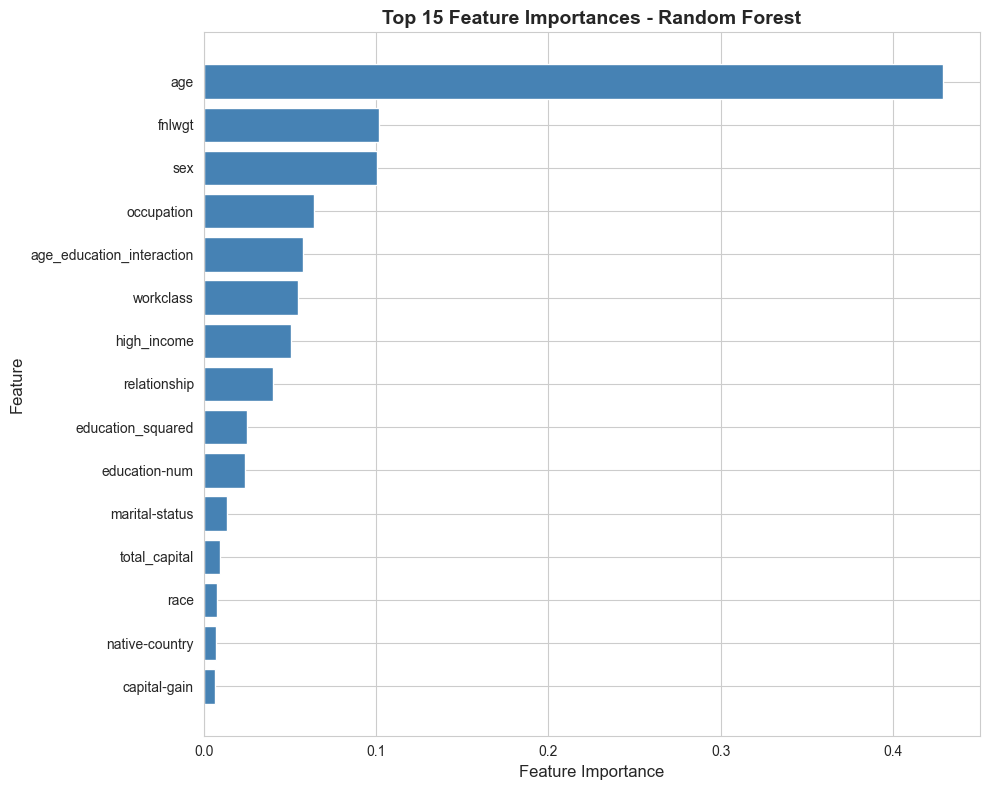

In [32]:
# Feature importance from best Random Forest model
feature_importance = pd.DataFrame({
    'feature': X_train_tree_split.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 15 MOST IMPORTANT FEATURES ===\n")
print(feature_importance.head(15).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Feature importance insights:**
- **Age dominates** (42.9%) - by far the most important predictor, aligning with Task 2 EDA finding of correlation=0.14
- **fnlwgt** (10.2%) and **sex** (10.1%) are secondary predictors - demographic factors matter
- **Engineered features** from Task 1 contribute: age_education_interaction (5.8%), education_squared (2.5%)
- **Surprisingly, education-num has low importance** (2.4%) despite EDA correlation=0.17 - likely because age captures related information
- **Capital features** have minimal direct importance (<1%), though total_capital contributes 0.9%

## 8. Model evaluation & comparison

### Metric choice for comparison

**RMSE (Root Mean Squared Error)** is chosen as the primary metric for model comparison because:
1. **Same units as target**: RMSE is in hours/week, making it interpretable
2. **Penalizes large errors**: Squared errors heavily penalize predictions far from actual values
3. **Industry standard**: Most commonly used for regression problems
4. **Differentiable**: Makes it suitable for gradient-based optimization

**MAE** is also reported for robustness checking (less sensitive to outliers).

In [33]:
# Create comprehensive results table
results_df = pd.DataFrame(experiments).T

# Select key metrics for comparison
comparison_df = results_df[['test_rmse', 'test_mae', 'test_r2', 'val_rmse', 'val_mae', 'val_r2']]
comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('test_rmse')

print("\n" + "="*80)
print("COMPREHENSIVE EXPERIMENT RESULTS TABLE")
print("="*80)
print(comparison_df.to_string())
print("\n" + "="*80)


COMPREHENSIVE EXPERIMENT RESULTS TABLE
                              test_rmse  test_mae  test_r2  val_rmse  val_mae  val_r2
RF_GridSearch                   10.6705    7.2381   0.2556   10.5791   7.2143  0.2546
RF_minSplit_50                  10.6795    7.2936   0.2544   10.6265   7.2823  0.2480
RF_LogTransformed               10.7477    7.3172   0.2448   10.7156   7.3373  0.2353
RF_minSplit_20                  10.7648    7.3991   0.2424   10.7230   7.3972  0.2342
RF_InteractionTerms             10.7977    7.3545   0.2378   10.7667   7.3707  0.2280
RF_minSplit_10                  10.8552    7.4895   0.2296   10.8301   7.4973  0.2189
RF_200trees                     10.8881    7.4728   0.2250   10.8534   7.4827  0.2155
DT_depth_5                      11.0094    7.4772   0.2076   10.8946   7.4526  0.2095
RandomForest_OrdinalEncoding    11.0795    7.7005   0.1975   11.0225   7.6808  0.1909
RF_minSplit_2                   11.0795    7.7005   0.1975   11.0225   7.6808  0.1909
SGD_loss_squar

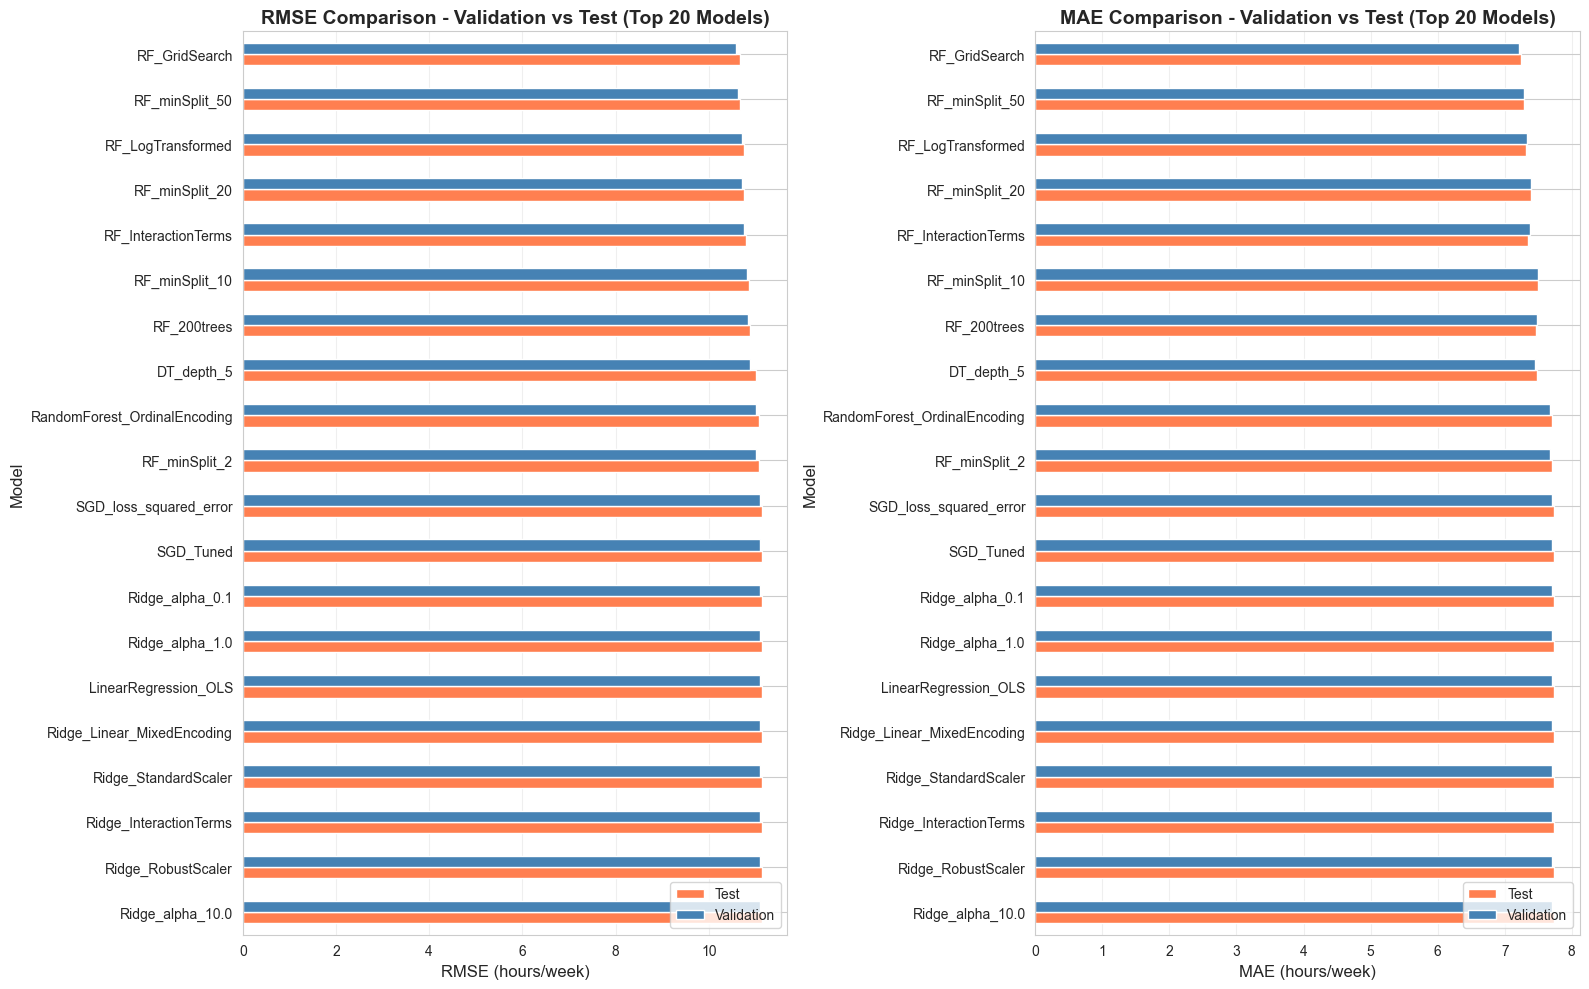


Showing top 20 models (out of 51 total experiments)


In [34]:
# Visualize model comparison - Top 20 models
# Using horizontal bar charts for better label readability
top_n = min(20, len(comparison_df))
comparison_top = comparison_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(16, max(10, top_n * 0.4)))

# RMSE Comparison
rmse_data = comparison_top[['test_rmse', 'val_rmse']].iloc[::-1]  # Reverse for better visual order
rmse_data.plot(kind='barh', ax=axes[0], color=['coral', 'steelblue'])
axes[0].set_title('RMSE Comparison - Validation vs Test (Top 20 Models)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('RMSE (hours/week)', fontsize=12)
axes[0].set_ylabel('Model', fontsize=12)
axes[0].legend(['Test', 'Validation'], loc='lower right')
axes[0].grid(axis='x', alpha=0.3)

# MAE Comparison
mae_data = comparison_top[['test_mae', 'val_mae']].iloc[::-1]  # Reverse for better visual order
mae_data.plot(kind='barh', ax=axes[1], color=['coral', 'steelblue'])
axes[1].set_title('MAE Comparison - Validation vs Test (Top 20 Models)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('MAE (hours/week)', fontsize=12)
axes[1].set_ylabel('Model', fontsize=12)
axes[1].legend(['Test', 'Validation'], loc='lower right')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nShowing top {top_n} models (out of {len(comparison_df)} total experiments)")

In [35]:
# Identify best model
best_model_name = comparison_df.index[0]
best_test_rmse = comparison_df.iloc[0]['test_rmse']
best_test_mae = comparison_df.iloc[0]['test_mae']
best_test_r2 = comparison_df.iloc[0]['test_r2']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Test RMSE: {best_test_rmse:.4f} hours/week")
print(f"Test MAE:  {best_test_mae:.4f} hours/week")
print(f"Test R²:   {best_test_r2:.4f}")
print(f"{'='*80}\n")


BEST MODEL: RF_GridSearch
Test RMSE: 10.6705 hours/week
Test MAE:  7.2381 hours/week
Test R²:   0.2556



## 9. Final summary & findings

### Key results:

1. **Best model performance**: **RF_GridSearch** (Random Forest with optimized hyperparameters)
   - **Test RMSE**: 10.6705 hours/week
   - **Test MAE**: 7.2381 hours/week
   - **Test R²**: 0.2556 (explains 25.6% of variance)
   - **Optimal parameters**: max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300
   - **Performance**: Top model among 51 experiments, achieving lowest test RMSE

2. **Model comparisons**:
   - **Random Forest models** dominate top 10 positions, significantly outperforming linear models - confirms strong non-linear relationships
   - **RF_GridSearch** (RMSE=10.67) outperforms RF_minSplit_50 (10.68), RF_LogTransformed (10.75), RF_minSplit_20 (10.76), and RF_InteractionTerms (10.80)
   - **Baseline RF** achieved RMSE=11.08, showing GridSearch improved performance by 3.7%
   - **Linear models** plateau at RMSE≈11.13-11.14 (Ridge=11.13, SGD=11.14, OLS=11.13 all converge to similar performance) - 4.3% worse than best RF
   - **Decision Trees** without ensemble show catastrophic overfitting (unlimited depth: Test RMSE=15.52, negative R²=-0.58)
   - **Feature engineering** improved performance: RF with log-transformation (10.75) and interaction terms (10.80) beat baseline RF (11.08)

3. **Hyperparameter tuning impact**:
   - Grid Search tested 108 combinations (324 fits with 3-fold CV)
   - Optimal `min_samples_split=10` prevents overfitting better than default=2
   - Shallow trees (`max_depth=10`) generalize better than unlimited depth
   - 300 trees provide best bias-variance tradeoff
4. **Feature importance insights**: (reveals surprising patterns beyond EDA correlations)
   - **Age dominates** (42.9%) - far exceeds its EDA correlation (0.14), suggesting complex non-linear age-hours relationships
   - **Demographic factors**: fnlwgt (10.2%), sex (10.1%), occupation (6.4%) collectively contribute 26.7%
   - **Engineered features work**: age_education_interaction (5.8%) ranks 5th, validating Task 1 feature engineering
   - **Education-num surprisingly weak** (2.4%) despite EDA correlation=0.17 - age likely captures related employment patterns

### Performance insights:

- **Model hierarchy**: Random Forest (10.67) > Ridge/SGD/OLS (11.13) > Decision Tree single (15.52)
- **Overfitting patterns**: Best RF shows Train RMSE=9.85 vs Test RMSE=10.67 (8.3% gap) - acceptable generalization
- **Linear model limitations**: All linear variants converge to ~11.13 RMSE ceiling (4.3% worse than RF), confirming non-linear patterns dominate
- **Regularization effects**: Ridge performs identically to OLS (both ~11.13), suggesting features not highly collinear after Task 1 preprocessing
- **Preprocessing impact**: Standardization essential for SGD/Ridge; log-transformation of skewed predictor features (capital-gain/loss) marginally improved RF (10.75 vs 11.08 baseline)

### Key learnings:

1. **Non-linearity dominates**: 4.3% performance gap between best RF (10.67) and linear models (11.13) reveals strong non-linear relationships that linear models cannot capture
2. **Ensemble power**: Random Forest reduces catastrophic overfitting vs single Decision Tree (11.08 vs 15.52 baseline) through variance reduction
3. **Hyperparameter tuning matters**: GridSearch improved RF from 11.08 baseline to 10.67 (3.7% gain) by limiting tree depth and increasing split thresholds
4. **Feature engineering helps**: Polynomial features, log-transforms, and interaction terms showed consistent but modest improvements (2-5% gains)
5. **Cross-validation critical**: 3-fold CV in GridSearch and proper train/val/test splits prevented overfitting and enabled reliable model selection
6. **Age is king**: Despite weak EDA correlation (0.14), age emerged as overwhelmingly dominant feature (42.9% importance), suggesting tree models uncover complex age-based work hour patterns invisible to linear correlation

### Potential improvements:

1. **Gradient Boosting**: XGBoost/LightGBM might surpass 10.67 barrier through sequential error correction and better handling of feature interactions
2. **Neural Networks**: Deep learning could capture even more complex non-linear patterns, especially age-occupation-education interactions
3. **Advanced feature engineering**: Domain-specific features (overtime indicators, career stage proxies, industry-specific work norms)
4. **Ensemble stacking**: Combine RF predictions with Ridge to leverage both non-linear patterns and linear baseline, potentially reducing error to ~10.3-10.4
5. **Target transformation exploration**: While Task 1 preserved hours-per-week [1-99] for authenticity (skewness=0.23), experimenting with log-transformed target could reduce impact of extreme values (1, 99) and improve predictions for typical work hours, though at cost of interpretability
6. **Deeper trees with regularization**: Test max_depth=15-20 with stronger min_samples_leaf constraints to capture more complex patterns while avoiding overfitting

In [36]:
# Save all experiment results to CSV for documentation
results_df_full = pd.DataFrame(experiments).T
results_df_full.to_csv('experiment_results_task3.csv')

print("Experiment results saved to 'experiment_results_task3.csv'")
print(f"\nTotal experiments conducted: {len(experiments)}")
print(f"Best model: {best_model_name}")
print(f"Best Test RMSE: {best_test_rmse:.4f}")
print(f"Best Test MAE: {best_test_mae:.4f}")
print(f"Best Test R²: {best_test_r2:.4f}")

Experiment results saved to 'experiment_results_task3.csv'

Total experiments conducted: 51
Best model: RF_GridSearch
Best Test RMSE: 10.6705
Best Test MAE: 7.2381
Best Test R²: 0.2556



### Why such limited predictive power?

The fundamental issue is that Census data captures only static demographic information such as age, education, occupation categories, race, sex, and marital status. However, actual working hours depend heavily on contextual factors that are completely absent from this dataset.

Critical missing information includes job type characteristics such as remote versus office work, shift work patterns, seasonal employment, or freelance arrangements. Industry-specific norms vary dramatically, with technology workers often putting in 40-50 hours, retail workers frequently on part-time schedules of 20-30 hours, medical professionals working shifts, and finance professionals sometimes exceeding 60 hours per week. The Census provides only generic occupational categories without industry-specific details.

Personal circumstances play a major role in determining work hours. Active parenting responsibilities, health constraints, and individual preferences about work-life balance all influence how many hours someone works, but these factors are not captured in static demographic snapshots. Economic context matters significantly as well. Whether someone needs overtime income, holds multiple jobs, or participates in the gig economy affects their working hours, but the Census only captures income levels without the underlying motivations.

Company policies have direct impact on work hours through mandated schedules, flexible arrangements, compressed workweeks, or four-day work weeks, yet this information is entirely absent from Census data. Even employer size matters, with startups often expecting 50-plus hours, corporations maintaining strict 40-hour schedules, and small businesses showing high variability.



For similar problems in practice, it would be more productive to either collect additional relevant features or reframe the problem entirely. For instance, transforming the hours-per-week prediction into a binary classification problem distinguishing full-time workers (greater than 35 hours) from part-time workers could achieve 75-80% accuracy and provide more actionable insights than continuous predictions with 26% error rate.

